# Learning Objectives of the LSTM tutorial:
* Build a simple LSTM 
* Become familiar with PyTorch
* Train models using GPU
* Use cloud hosted data (via AWS S3 -  streamflow-app-data bucket)


In [1]:
#basic packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#modeling packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

#Modeling scripts from scripts folder
from scripts.Simple_LSTM import readdata, create_tensors, Simple_LSTM, train_LSTM, plot, LSTM_load, model_eval

#See if you system is using GPU (cuda) or cpu. We want to run on cpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [2]:
#read parquet file from AWS s3 - put in credentials or updated script to not need them
filepath = 'RJ/data/exampledata.parquet'
df = readdata(filepath)

#changes date as str to datetime object
df['Month'] = df['Month'].astype('datetime64[ns]')
df.set_index('Month', inplace = True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


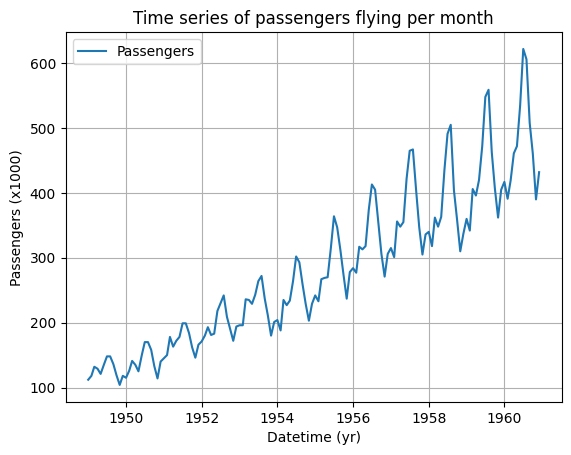

In [3]:
#plot the data
plot(df)

In [4]:
#split data into train/test - note, for LSTM there is not need to randomize the split
timeseries = df[["Passengers"]].values.astype('float32') #conver the df into an array

trainsize = int(len(timeseries)*0.67) # 67% of data for training
testsize = len(timeseries)-trainsize # remaining (~33%) data for testing

train, test = timeseries[:trainsize], timeseries[-testsize:]


We typically perform simple time series prediction on a moving window (w), given data from t -w to t, with w governing how much data the model can look back on (i.e., look back period).
On a long timeseries, the developer can create multiple overlapping windows, and it is convienant to create a function to generate a dataset of a fixed window from the time series.
Since we are using PyTorch, we need to convert the dataset into tensors.

The design of the create_tensors() function is to apply windows on the time series in order to predict at timestep t+1, converting the time series into a a tensor of dimensions (window sample, time steps, features). 
A time series of n timesteps can produce approximately n windows (e.g., a window can start at any time step given the window does not exceed the boundaries of the time series). 
Within the window are multiple consecutive time steps of values, and in each time step there can be mutliple features (see [Feature_LSTM](Feature_LSTM.ipynb)).

Data processing steps must produce the features and target into the same shape. 
Example, for a window of 3 timesteps, the features are the time series from t to t+2 and the targets are from t+1 to t+3. 
We are looking to predict for t+3 but the information in t+1 and t+2 is useful for training.
From our create_tensors() function, the input time series is a 2D array and the output will be a 3D tensor.
We call the window the lookback and its setting determines how many previous time steps the model can look back to inform a prediction.
The **lookback** value is a very important value for an LSTM. 
Lets explore.

In [9]:
#set lookback
lookback = 4 #

#create testing and training tensors
X_train, y_train =  create_tensors(train, lookback = lookback)
X_test, y_test =  create_tensors(test, lookback = lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 4, 1]) torch.Size([92, 4, 1])
torch.Size([44, 4, 1]) torch.Size([44, 4, 1])


# Build the LSTM
![PyTorchLSTM](Images/PytorchLSTM.JPG)

For more detailed information, please visit the [Pytorch LSTM documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

## Model Set up
We can now build the LSTM model to predict the time series using the Simple_LSTM() class from [Simple_LSTM.py](/scripts/Simple_LSTM.py).

The torch.nn call uses nn.LSTM() that accepts inputsize, hidden_size, num_layers, and batchfirst as inputs, generating a tuple as an output. 
The first element of the tuple is the generate hidden state, one for each time step of the input.
The second element is the LSTM cell  memory adn hidden states which we will not use.

We create an LSTM layer by setting the batchfirst variable to True, which makes use of the input tensors of dimensions (window sample, time steps, features).
The model creates a batch by sampling the first dimension.

The last function in the LSTM is for processing the fully connected LSTM output into a single regression result (e.g., self.linear = nn.Linear()). 
The output of the model will form as an input for the next time step.

We will select MSE as the loss function because we are performing a regression task, which will seek to minimize through the applicaiton of the Adam optimizer.
Below, we load the Simple_LSTM() class and combine with the PyTorch tensors using torch.utils.data.TensorDataset() and batch training provided by DataLoader.
A DataLoader automatically creates minibatches of the dataset for the training process and speeds up the data loading process by parallelizing the loading of data from disc to the GPU/CPU.
[Leaky.ai](https://www.leaky.ai/dataloader) provides additional information how to set up a dataloader
During model training, the model evaluates its performance once per 100 epochs, on both the training and testing datasets.

From this tutorial, we see the data size (~144 obs, small dataset), batch size, and the number of epoch influencing model training time.

In [34]:
#Inputs and model parameters
input_size = 1 #the number of expected feaures in the input x
hidden_size = 50 # the number of features in the hidden state h, for this example, hidden layers < 30 perform poorly and there is minimal improvement with layers > 50
num_layers = 1 #the number of recurrent layers. E.g., setting to 2 means stacking 2 LSTMS together to form a stacked LSTM with the second taking the outputs from the first
batch_size = 30 #Typically set the batch size to loop through 64-128 samples at a time, our dataset is small so we set to 30, batch size should always be smaller than the training dataset
batchfirst = True #if True, the the input and output tensors are (batch, seq, feature) instead of (seq, batch, feature)
n_epochs = 7000 # Originally set to a batch size of 8 and 2000 epochs. 
save_model = True
test_score = True
model_path = 'models/Simple_LSTM/best_model.pt'

#Load model class
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
#connect to GPU device - will default to cpu if there is no GPU available
model.to(device)
# set optimizer
optimizer = optim.Adam(model.parameters())
#set loss function
loss_fn = nn.MSELoss()
#set dataloader function
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

#set configurations dictionary
config_dict = {
            'X_train': X_train, 
            'y_train' : y_train,
            'X_test': X_test,
            'y_test': y_test,
            'n_epochs': n_epochs,
            'model': model, 
            'loader': loader, 
            'optimizer': optimizer, 
            'loss_fn': loss_fn, 
            'save_model': save_model, 
            'model_path': model_path, 
            'test_score': test_score,
}


#Train the LSTM
train_LSTM(config_dict)


Epoch 0: train RMSE 226.1260, test RMSE 425.3628
Epoch 100: train RMSE 207.6535, test RMSE 406.1620
Epoch 200: train RMSE 193.1265, test RMSE 390.9319
Epoch 300: train RMSE 179.2005, test RMSE 376.1766
Epoch 400: train RMSE 166.0387, test RMSE 362.0465
Epoch 500: train RMSE 153.7256, test RMSE 348.6097
Epoch 600: train RMSE 142.1227, test RMSE 335.6848
Epoch 700: train RMSE 130.2813, test RMSE 322.1250
Epoch 800: train RMSE 119.9486, test RMSE 309.8541
Epoch 900: train RMSE 110.5603, test RMSE 298.1779
Epoch 1000: train RMSE 102.2602, test RMSE 287.2189
Epoch 1100: train RMSE 95.1580, test RMSE 277.1086
Epoch 1200: train RMSE 87.8927, test RMSE 266.5129
Epoch 1300: train RMSE 79.3882, test RMSE 254.9507
Epoch 1400: train RMSE 72.3985, test RMSE 243.8925
Epoch 1500: train RMSE 66.6870, test RMSE 233.9123
Epoch 1600: train RMSE 61.4254, test RMSE 224.2513
Epoch 1700: train RMSE 56.6152, test RMSE 214.9638
Epoch 1800: train RMSE 52.5468, test RMSE 206.7185
Epoch 1900: train RMSE 48.4211, 

Train RMSE 19.3784, test RMSE 72.3384


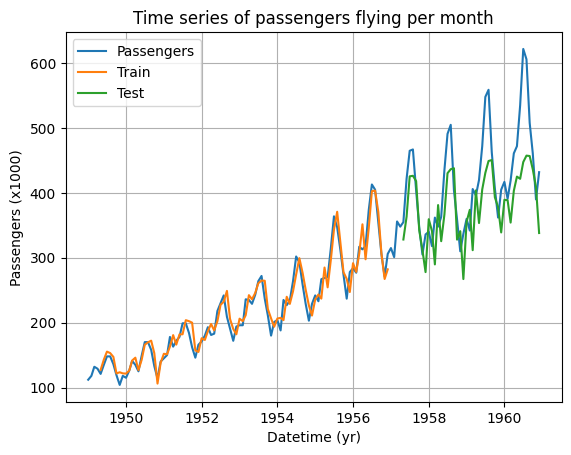

In [35]:
#load model and make predictions on training and testing datasets
model = Simple_LSTM(input_size, hidden_size, num_layers, batchfirst)
model = LSTM_load(model, model_path)

#Evaluate model
df = model_eval(df, model, lookback, X_train, X_test, y_train, y_test, timeseries, trainsize, loss_fn)

In [17]:
df.head()

,Passengers,Train,Test
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,129.093155,NaN
